# 11-6. 프로젝트 : 폐렴 진단기 성능개선
## Step 1. 실험환경 Set-up
#### Batch size, Epoch 등을 변경

In [53]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 30
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


##  Step 2. 데이터 준비하기


In [54]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

a=train_filenames
b=test_filenames
c=val_filenames



5216
624
16


In [55]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
# train은 4185개, test는 624개, val은 1047개

4185
1047


In [56]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0400-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1152-0001.jpeg


In [57]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1083
Pneumonia images count in training set: 3102


- 폐렴의 수: 정상의 3배
- CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 한다.
- 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정
- test,val은 평가하기 위해서 사용된다. (training 영향이 없음) imbalanced해도 괜찮다

In [58]:
#tf.data 인스턴스 만들기: tf.data는 tensorflow에서 학습 시킬 때 배치처리 작업을 보다 효율적으로 할 수 있게 해줌
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [59]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 라벨데이터 만들기


In [60]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 사이즈통일 및 줄이기
process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다

In [61]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.



In [62]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [63]:
#확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
    # train_ds.take(1)은 하나의 데이터만 가져온다는 의미

Image shape:  (180, 180, 3)
Label:  False


### test 데이터셋 만들기


In [64]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- tensorflow에서는 tf.data 파이프라인을 사용해서 학습 ㄷ이터를 효율적으로 사용하기
- prepare_for_training()함수는 학습데이터를 효율적으로 학습할 수 있또록 데이터를 변환
- shuffle() 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat() ecpoch를 진행하면서 여러번 데이터셋을 불러오는에 repeat()를 사용한 데이터의 경우 여러번 데이터셋을 사용하게 함 , 예: 100개의 데이터를 10번반복하면 1000개의 데이터가 필요. repeat()를 사용하면 자동으로 데이터를 맞춰준다.

- batch() BATCH_SIZE에서 정한 만큼의 배치로 주어진다. 예로 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉜다.

- prefech() 학습데이터를 나눠서 읽어오기 때문에 첫 번째 데이터를 GPU에서 학습하는 동안 두번째 데이터를 CPU에서 준비할 수 있어 리소스 유휴상태를 줄일 수 있다.

 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인

In [65]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화
- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출. 추출된 배치를 image와 label 데이터 셋으로 나누기. show_batch() 함수를 이용해서 결과 사진을 확인

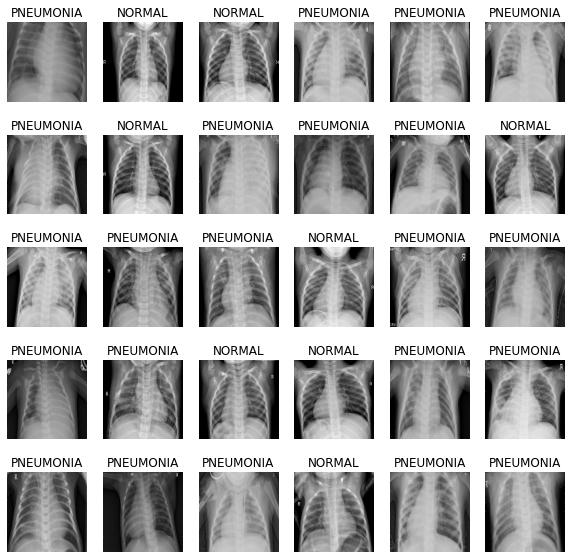

In [66]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링


- Convolution block을 만들기. 
conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결하기. 그리고나서 Max Pooling 하기

### 시도해 볼 것
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해보기
- Convolution filter 
- 채널 개수
- activation 
- 모델 구조 등

그리고, 기존 모델에서는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습
이것은 일반적으로 잘 사용되는 형태기 아님. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 한다. 만약 이 구성을 변경해  어떤 효과가 발생하는지도 실험하기.
- BatchNormalization을 쓰거나 혹은 쓰지 않기
- Dropout을 쓰거나 혹은 쓰지 않기
- Dropout 비율을 변경

In [67]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [68]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [69]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3), #drop out 0.3
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3), #drop out 0.3
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid') 
    ])
    
    return model

## Step 5. 데이터 imbalance 처리
### 데이터 imbalance 문제해결

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있다. 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.

**Weight balancing**이라는 테크닉이 사용된다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 **특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법**이다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다.weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅하고 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정하기

### 시도할 것
- 실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었는데 만약 이러한 처리를 생략한다면 어떻게 될까?
- 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼  방법은?

In [70]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련


- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택. 
- 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언.
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용. 
- optimizer로 'adam'을 사용
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

### 시도할 것
- optimizer나 learning rate 등의 변화를 고려

In [71]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [72]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
139/139 [==============================] - 78s 250ms/step - loss: 0.4819 - accuracy: 0.7615 - precision: 0.9392 - recall: 0.7246 - val_loss: 0.6043 - val_accuracy: 0.7431 - val_precision: 0.7431 - val_recall: 1.0000
Epoch 2/25
139/139 [==============================] - 34s 242ms/step - loss: 0.2534 - accuracy: 0.8999 - precision: 0.9746 - recall: 0.8877 - val_loss: 0.7920 - val_accuracy: 0.7461 - val_precision: 0.7461 - val_recall: 1.0000
Epoch 3/25
139/139 [==============================] - 34s 245ms/step - loss: 0.2072 - accuracy: 0.9267 - precision: 0.9715 - recall: 0.9275 - val_loss: 1.0359 - val_accuracy: 0.7451 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 4/25
139/139 [==============================] - 34s 241ms/step - loss: 0.1555 - accuracy: 0.9405 - precision: 0.9784 - recall: 0.9399 - val_loss: 1.3705 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 5/25
139/139 [==============================] - 34s 242ms/step - loss: 0.1427 - accura

## Step 7. 결과 확인과 시각화
- accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요.
- 훈련과정의 history 그래프를 시각화 
- 학습 진행 양상을 면밀히 분석하기

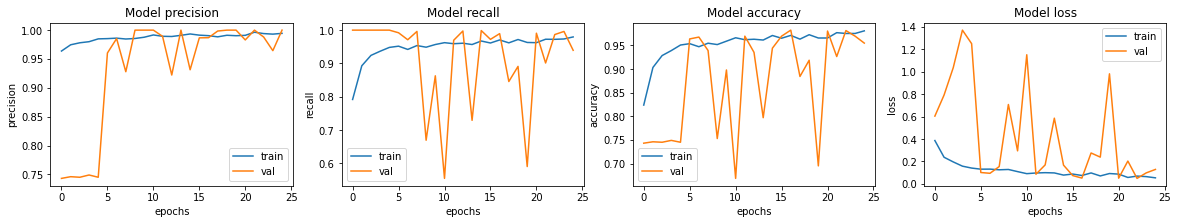

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [74]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

21/21 [==============================] - 13s 653ms/step - loss: 0.5734 - accuracy: 0.8574 - precision: 0.8322 - recall: 0.9667
Loss: 0.5733525156974792,
Accuracy: 0.8573718070983887,
Precision: 0.8322295546531677,
Recall: 0.9666666388511658
